# Dimensionality Reduction
Luther Richardson  
4-28-21
- This project downloads at least 200 Pubmed articles. 100 include the term “obesity” and the other 100 include the term “cancer”. 
- Their textual corpus is analyzed to feed them into a dimensionality reduction method.
- Finally, Principal Component Analysis (PCA), T-distributed stochastic neighbor embedding (tSNE), and Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) algorithms are applied to the dataset to visualize the 
- You need to prepare a report on your tasks and findings along with a video file describing what you have done. You can copy paste your codes, its results and your description into a Word document, Python Notebook or you can use R notebook.

## Import modules


In [97]:
import os.path
import gensim
from gensim import corpora
from gensim import models
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
from pymed import PubMed
import pandas as pd
import json
import matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np 
from matplotlib import pyplot as plt 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luther/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define key methods

In [99]:
# Performs a pubmed search with a keyword and number of articles requested
def pubmed_search_to_csv(search_term, num_articles):
    # Create a PubMed object that GraphQL can use to query
    # https://www.ncbi.nlm.nih.gov/pmc/tools/developers/
    # pubmed configuration
    pubmed = PubMed(tool="Tool3", email="l.zilli@bu.edu")
    # Create a query in plain text
    query = f'(({search_term}[Title/Abstract]))'
    # Execute the query against the API
    search_results = list(pubmed.query(query, max_results=num_articles + 1))
    # Clean up the result
    titles = []
    for item in search_results:
        titles.append(str(item.title))
    # dump to CSV
    df = pd.DataFrame(titles)
    df.to_csv(f"{search_term}_pubmed_search_results.csv")

# import the data
def load_data(path, column):
    data = pd.read_csv(path,
                       low_memory=False)
    data = data[column]
    documents = data.values.tolist()
    print("Documents:",len(data))
    return documents

# Get data from PubMed
Search for 100 articles each on cancer and obesity

In [75]:
pubmed_search_to_csv('obesity', 200)
pubmed_search_to_csv('cancer', 200)

# Prepare for dimensionality reduction

In [100]:
# filenames for import
files = ["cancer_pubmed_search_results.csv","obesity_pubmed_search_results.csv"]

In [101]:
documents = []

for file in files:
    data = load_data(file,'0')
    for title in data:
        documents.append(title)

Documents: 201
Documents: 201


## Example document titles

In [102]:
for doc in documents[0:5]:
    print(doc)

Diagnosis and management of pharyngoesophageal stenosis: A comprehensive approach to prophylactic, endoscopic, and reconstructive treatment options.
Synergistic effects of autocrine motility factor and methyl jasmonate on human breast cancer cells.
PHF19 inhibition as a therapeutic target in multiple myeloma.
A deep learning based multiscale approach to segment the areas of interest in whole slide images.
Micropatterned growth surface topography affects extracellular vesicle production.


## How many documents?

In [78]:
len(documents)

402

# Start creating the bag of words

## Cleanup of the dataset

In [79]:
def clean_doc(item):
    item = re.sub("\W|[0-9]", " ", item) # remove non alpha
    item = re.sub("\s+", " ", item) # remove more than one space
    item =  item.lower() # lowercase 
    return str(item)

In [80]:
stop_words = set(stopwords.words('english'))

## Tokenize

In [82]:
tokenized_docs = []

for doc in documents:
    # tokenize removing len less than 3 and over 15 char
    doc = clean_doc(str(doc))
    doc = gensim.utils.simple_preprocess(doc, min_len=4, max_len=15)
    removed_stops = []
    for word in doc:
        if (word not in stop_words):
            removed_stops.append(word)
    tokenized_docs.append(removed_stops)

## Rejoin bag of words with stop words and short words removed

In [83]:
joined_docs = []
for doc in tokenized_docs:
    joined_docs.append(" ".join(doc))

# Convert list documents into TFIDF

Create TFIDF Term Frequency Inverse Document Frequenct
* Summarizes how often a word appears in a document
* Downscales words that appear often across docs

In [84]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(joined_docs)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df = df.reset_index() # convert index into column
df = df.rename(columns = {'index':'word'})
print(df.head())

             word   TF-IDF
0    prophylactic  0.35303
1  reconstructive  0.35303
2        stenosis  0.35303
3         options  0.35303
4   comprehensive  0.33033


## Convert to dict in order to build table

In [85]:
my_dict = {}
i = 0
for row in df['word'] :
    my_dict[f'{df["word"][i]}'] = df['TF-IDF'][i]
    i+=1

## Set up a new dataframe with all words as headers

In [103]:
headers = df.word
word_matrix = pd.DataFrame(columns=headers)

In [130]:
print(word_matrix)

word  prophylactic  reconstructive  stenosis  options  comprehensive  \
0          0.35303         0.35303   0.35303  0.35303        0.33033   
1          0.00000         0.00000   0.00000  0.00000        0.00000   
2          0.00000         0.00000   0.00000  0.00000        0.00000   
3          0.00000         0.00000   0.00000  0.00000        0.00000   
4          0.00000         0.00000   0.00000  0.00000        0.00000   
..             ...             ...       ...      ...            ...   
397        0.00000         0.00000   0.00000  0.00000        0.00000   
398        0.00000         0.00000   0.00000  0.00000        0.00000   
399        0.00000         0.00000   0.00000  0.00000        0.00000   
400        0.00000         0.00000   0.00000  0.00000        0.00000   
401        0.00000         0.00000   0.00000  0.00000        0.00000   

word  endoscopic  diagnosis  approach  management  treatment  ...  formalism  \
0       0.301732   0.301732  0.282894    0.275419   0.2

## Get the TF-IDF metric into the matrix for each document

In [104]:
i = 0
for doc in tokenized_docs:
    # print(doc)
    for word in doc:
        column = word
        value = my_dict.get(word)
        # print(i,column,value)
        word_matrix.at[i, column] = value
        #word_matrix.at[i, 'data_tag'] = 'Cancer'
    i+=1
# remove all NaN
word_matrix = word_matrix.fillna(0)

## We now have word frequencies by doc and are ready for dimensionality reduction

In [105]:
print(word_matrix)
print(print(word_matrix.loc[[1]]['cancer']))

word  prophylactic  reconstructive  stenosis  options  comprehensive  \
0          0.35303         0.35303   0.35303  0.35303        0.33033   
1          0.00000         0.00000   0.00000  0.00000        0.00000   
2          0.00000         0.00000   0.00000  0.00000        0.00000   
3          0.00000         0.00000   0.00000  0.00000        0.00000   
4          0.00000         0.00000   0.00000  0.00000        0.00000   
..             ...             ...       ...      ...            ...   
397        0.00000         0.00000   0.00000  0.00000        0.00000   
398        0.00000         0.00000   0.00000  0.00000        0.00000   
399        0.00000         0.00000   0.00000  0.00000        0.00000   
400        0.00000         0.00000   0.00000  0.00000        0.00000   
401        0.00000         0.00000   0.00000  0.00000        0.00000   

word  endoscopic  diagnosis  approach  management  treatment  ...  formalism  \
0       0.301732   0.301732  0.282894    0.275419   0.2

# PCA dimensionality reduction

## Break out values for scatter plot

/Users/luther/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/features/pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


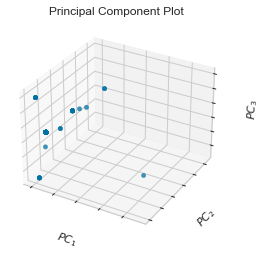

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [129]:
from yellowbrick.features import PCA
from yellowbrick.features import pca_decomposition

visualizer = PCA(scale=True, classes=classes, projection = 3)
visualizer.fit_transform(word_matrix)
visualizer.show()

# tSNE dimensionality reduction

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


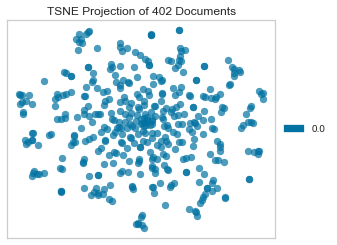

<AxesSubplot:title={'center':'TSNE Projection of 402 Documents'}>

In [94]:
# Load the data and create document vectors
corpus = word_matrix
tfidf = TfidfVectorizer()

X = tfIdf
y = corpus.target

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

# UMAP dimensionality reduction

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


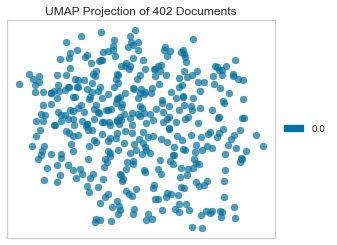

<AxesSubplot:title={'center':'UMAP Projection of 402 Documents'}>

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.datasets import load_hobbies
from yellowbrick.text import UMAPVisualizer

# Load the text data
corpus = word_matrix
tfidf = TfidfVectorizer()
docs = tfIdf
labels = corpus.target

# Instantiate the text visualizer
umap = UMAPVisualizer()
umap.fit(docs, labels)
umap.show()

### Conclusions
#### PCA
This one, of the three, was the hardest to interpret. The clustering is too sparse to understand what is really going on in the plot. 
#### TSNE
I think this did the best job clustering results. There were a number of very clear clusters and if I were in the field this is likely what I would use for this dataset. 
#### UMAP
Clusers in this graph were clear but the overall dataset was much more diffuse. I think that this would still be useful, but in this case preferred TSNE